In [ ]:
import torch
import os
import csv
import pandas as pd
from torchvision import datasets
from torch.utils.data.dataset import Dataset
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path
from torchsummary import summary
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torch.utils.data.sampler import SubsetRandomSampler

##Load Data

In [ ]:
transform = transforms.Compose(transforms.ToTensor())

In [ ]:
train_data_dir = '/content/drive/MyDrive/ColabNotebooks/DL/HW/final-project-dl-spring-2020.zip (Unzipped Files)/train_data/train'
test_data_dir = '/content/drive/MyDrive/ColabNotebooks/DL/HW/final-project-dl-spring-2020.zip (Unzipped Files)/test_data/'

In [ ]:
train_dataset = datasets.ImageFolder(train_data_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_data_dir, transform=transform)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(len(train_dataset.imgs))
print(len(test_dataset.imgs))

9025
3929


In [ ]:
print(train_dataset.classes)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


## Preprocessing

In [ ]:
torch.manual_seed(0)
valid_size =0.2
n_train = len(train_dataset)
indices = torch.randperm(n_train)
split = torch.floor(torch.tensor(valid_size) * n_train)
split=split.type(torch.int32)
train_idx, valid_idx = indices[split:], indices[:split]
    
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [ ]:
train_transformer = transforms.Compose([
		transforms.RandomResizedCrop(224, scale=(0.08, 1.0), ratio=(3.0/4.0, 4.0/3.0)),
		transforms.RandomHorizontalFlip(),
		transforms.ToTensor(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
		# Standardize each channel of the image
		transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

test0_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

In [ ]:
train_dataset.transform=train_transformer
test_dataset.transform=test0_transformer

In [ ]:
torch.manual_seed(0)
batch_size=64
train_loader= torch.utils.data.DataLoader(dataset=train_dataset,
                                        batch_size=batch_size,
                                        #shuffle=True,
                                        sampler=train_sampler,
                                        num_workers=4)
torch.manual_seed(0)
valid_loader= torch.utils.data.DataLoader(dataset=train_dataset,
                                        batch_size=batch_size,
                                        #shuffle=True,
                                        sampler=valid_sampler,
                                        num_workers=4)

In [ ]:
torch.manual_seed(0)
test_loader= torch.utils.data.DataLoader(dataset=test_dataset,
                                        batch_size=batch_size,
                                        shuffle=False,
                                        num_workers=4)

In [ ]:
def train_loop(model, criterion, optimizer, train_loader, valid_loader, epochs,file,
               early_stopping=True, patience =3):

  train_losses= []
  valid_losses= []
  learning_rates=[]

  early_stop= False
  valid_loss_min = np.Inf
  delta =0
  best_score=None
  counter_early_stop = 0

  for epoch in range(epochs):
    
    t0= datetime.now()
    train_loss=[]  
    model.train()
    for input,targets in train_loader:
      # load input and output to GPU
      input = input.to(device)
      targets= targets.to(device)
      
      # forward pass
      output= model(input)
      loss=criterion(output,targets)

      # set gradients to zero 
      optimizer.zero_grad()

      # backward pass
      loss.backward()
      optimizer.step()
      train_loss.append(loss.item())
    
    #scheduler.step()

    train_loss=np.mean(train_loss)
        
    valid_loss=[]
    model.eval()
    with torch.no_grad():
      for input,targets in valid_loader:
        # load input and output to GPU
        input = input.to(device)
        targets= targets.to(device)
        
        # forward pass
        output= model(input)
        loss=criterion(output,targets)
        valid_loss.append(loss.item())

      valid_loss=np.mean(valid_loss)
    
    # save Losses
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    dt= datetime.now()-t0
    
    learning_rates.append(scheduler.get_last_lr())
    
    print(f'Epoch {epoch+1}/{epochs}, Learning Rate : {scheduler.get_last_lr()}')
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}    Valid Loss: {valid_loss:.4f}, Duration: {dt}')

    ## Early Stopping
    if early_stopping:
      score = -valid_loss

      if best_score is None:
          best_score = score
          print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
          torch.save(model.state_dict(), file)
          valid_loss_min = valid_loss
          
      elif score < best_score + delta:
          counter_early_stop += 1
          print(f'Early Stopping counter: {counter_early_stop} out of {patience}')
          if counter_early_stop >= patience:
              early_stop = True
      else:
          best_score = score
          print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
          torch.save(model.state_dict(), file)
          counter_early_stop = 0
          valid_loss_min = valid_loss

      if early_stop:
        print("Early stopping")
        break
    else:
      torch.save(model.state_dict(), file)

  return train_losses, valid_losses

In [ ]:
def get_accuracy(model, data_loader):
  model.eval()
  with torch.no_grad():
    correct=0
    total=0  
    for inputs, targets in data_loader:
      # move variables to GPU
      inputs= inputs.to(device)
      targets= targets.to(device)
  
      # forward pass      
      outputs = model(inputs)
      
      # torch.max() gives both value and indices
      _, predictions= torch.max(outputs,dim=1)
      correct_count= (targets==predictions).sum().item()
      correct+=correct_count
      total += targets.shape[0]
         
    # calculate accuracy  
    acc= correct/total
    
  return acc

In [ ]:
!pip install torch-lr-finder

In [ ]:
folder = Path('/content/drive/MyDrive/ColabNotebooks/DL/HW/')

In [ ]:
def get_predictions(model, data_loader):
  model.eval()
  with torch.no_grad():
    correct=0
    total=0  
    predictions= np.array([])
    for inputs, targets in data_loader:
      # move variables to GPU
      inputs= inputs.to(device)
      targets= targets.to(device)
  
      # forward pass      
      outputs = model(inputs)
      
      # torch.max() gives both value and indices
      #_, predictions= torch.max(outputs,dim=1)
      _,indices = torch.max(outputs,dim=1)
      predictions=np.concatenate((predictions,indices.cpu().numpy())) 

    return predictions

In [ ]:
image_list=[]
for i in range(0,len(test_dataset)):
  image_name=str(test_dataset.imgs[i]).split('/')[-1].split('\'')[0]
  image_list.append(image_name)


In [ ]:
print(image_list)

['0.JPEG', '1.JPEG', '10.JPEG', '100.JPEG', '1000.JPEG', '1001.JPEG', '1002.JPEG', '1003.JPEG', '1004.JPEG', '1005.JPEG', '1006.JPEG', '1007.JPEG', '1008.JPEG', '1009.JPEG', '101.JPEG', '1010.JPEG', '1011.JPEG', '1012.JPEG', '1013.JPEG', '1014.JPEG', '1015.JPEG', '1016.JPEG', '1017.JPEG', '1018.JPEG', '1019.JPEG', '102.JPEG', '1020.JPEG', '1021.JPEG', '1022.JPEG', '1023.JPEG', '1024.JPEG', '1025.JPEG', '1026.JPEG', '1027.JPEG', '1028.JPEG', '1029.JPEG', '103.JPEG', '1030.JPEG', '1031.JPEG', '1032.JPEG', '1033.JPEG', '1034.JPEG', '1035.JPEG', '1036.JPEG', '1037.JPEG', '1038.JPEG', '1039.JPEG', '104.JPEG', '1040.JPEG', '1041.JPEG', '1042.JPEG', '1043.JPEG', '1044.JPEG', '1045.JPEG', '1046.JPEG', '1047.JPEG', '1048.JPEG', '1049.JPEG', '105.JPEG', '1050.JPEG', '1051.JPEG', '1052.JPEG', '1053.JPEG', '1054.JPEG', '1055.JPEG', '1056.JPEG', '1057.JPEG', '1058.JPEG', '1059.JPEG', '106.JPEG', '1060.JPEG', '1061.JPEG', '1062.JPEG', '1063.JPEG', '1064.JPEG', '1065.JPEG', '1066.JPEG', '1067.JPEG', 

## Model : Inception v3

In [ ]:
inception_v3 = torchvision.models.inception_v3(pretrained=True)
inception_v3

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
for param in inception_v3.parameters():
    param.requires_grad = True

In [ ]:
# change the last layer
inception_v3.fc = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 10))
print(inception_v3)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
inception_v3.to(device)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
lr=0.0001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(inception_v3.parameters(), lr=lr,nesterov=True, momentum=0.9)

In [ ]:
from torch_lr_finder import LRFinder
lr_finder = LRFinder(inception_v3, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=10, num_iter=100, step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 2.98E-02


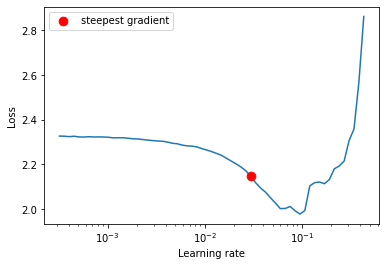

In [ ]:
lr_finder.plot()
lr_finder.reset()

In [ ]:
optimizer = torch.optim.SGD(inception_v3.parameters(), lr=2.98E-02,nesterov=True, momentum=0.9)

In [ ]:
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=2, gamma=0.95)

In [ ]:
file = folder / "Project_model_2.pt"
losses_train, losses_valid =  train_loop(inception_v3, criterion, optimizer, train_loader, 
                                         valid_loader, epochs=10,file = file)

Epoch 1/10, Learning Rate : [0.0298]
Epoch 1/10, Train Loss: 0.3656    Valid Loss: 0.7801, Duration: 0:01:09.618965
Validation loss decreased (inf --> 0.780121).  Saving model ...
Epoch 2/10, Learning Rate : [0.0298]
Epoch 2/10, Train Loss: 0.3660    Valid Loss: 0.7762, Duration: 0:01:08.610587
Validation loss decreased (0.780121 --> 0.776158).  Saving model ...
Epoch 3/10, Learning Rate : [0.0298]
Epoch 3/10, Train Loss: 0.3785    Valid Loss: 0.7162, Duration: 0:01:08.738044
Validation loss decreased (0.776158 --> 0.716215).  Saving model ...
Epoch 4/10, Learning Rate : [0.0298]
Epoch 4/10, Train Loss: 0.3734    Valid Loss: 0.7670, Duration: 0:01:09.057618
Early Stopping counter: 1 out of 3
Epoch 5/10, Learning Rate : [0.0298]
Epoch 5/10, Train Loss: 0.3527    Valid Loss: 0.8036, Duration: 0:01:08.796338
Early Stopping counter: 2 out of 3
Epoch 6/10, Learning Rate : [0.0298]
Epoch 6/10, Train Loss: 0.3613    Valid Loss: 0.8594, Duration: 0:01:08.778317
Early Stopping counter: 3 out of

In [ ]:
inception_v3.load_state_dict(torch.load(file))

<All keys matched successfully>

In [1]:
train_acc = get_accuracy(model =inception_v3,data_loader=train_loader)
valid_acc = get_accuracy(model =inception_v3,data_loader=valid_loader)
print(f'Train acc: {train_acc}, Validation acc: {valid_acc}')

Train acc: 0.985180055401662, Validation acc: 0.9217174515235457


In [ ]:
predictions = get_predictions(model =inception_v3,data_loader=test_loader)
print(predictions)

[7. 2. 0. ... 8. 3. 6.]


In [ ]:
output = pd.DataFrame(predictions,image_list)
output.to_csv("/content/drive/My Drive/ColabNotebooks/DL/project_pred_v7.csv")